In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import os

writer = SummaryWriter('runs/q1')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# initialize the dataset and split it into train and test sets with a ratio of 70:30
# transform normalize and resize the images to 150*150
transform = transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.ImageFolder(root='Shoe vs Sandal vs Boot Dataset', transform=transform)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

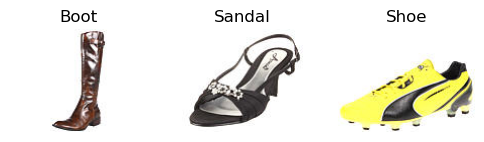

In [3]:
def plot_images(num_images=1, root_dir="Shoe vs Sandal vs Boot Dataset"):
    classes = os.listdir(root_dir)
    plt.figure(figsize=(len(classes) * 2, num_images * 2))
    for i in range(len(classes)):
        for j in range(num_images):
            # get a random image from the class
            img_name = np.random.choice(os.listdir(os.path.join(root_dir, classes[i])))
            img_path = os.path.join(root_dir, classes[i], img_name)
            img = plt.imread(img_path)
            plt.subplot(num_images, len(classes), i * num_images + j + 1)
            plt.imshow(img)
            plt.title(classes[i])
            plt.axis("off")
    plt.show()
plot_images()

In [4]:
class MLP(nn.Module):
    def __init__(self, hidden_layers):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_layers) - 1):
            self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        for i, linear in enumerate(self.hidden_layers):
            if i != len(self.hidden_layers) - 1:
                x = F.relu(linear(x))
                x = self.dropout(x)
            else:
                x = self.softmax(linear(x))
        return x

In [6]:
hidden_layers = [150 * 150 * 3, 128, 64, 3]
fc_model = MLP(hidden_layers).to(device)
# add the model to the tensorboard
writer.add_graph(fc_model, torch.rand(1, 3, 150, 150).to(device))
writer.close()
criterion = nn.CrossEntropyLoss()


In [20]:
# define a function to train the model that returns the loss and accuracy on the train set and the test set
def train(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0
        train_acc = 0
        test_acc = 0
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (outputs.argmax(1) == labels).sum().item()
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                test_acc += (outputs.argmax(1) == labels).sum().item()
        train_losses.append(train_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))
        train_accs.append(train_acc / len(train_dataset))
        test_accs.append(test_acc / len(test_dataset))
        print(f"Epoch {epoch + 1}/{epochs}.. "
              f"Train loss: {train_loss / len(train_loader):.3f}.. "
              f"Test loss: {test_loss / len(test_loader):.3f}.. "
              f"Train accuracy: {train_acc / len(train_dataset):.3f}.. "
              f"Test accuracy: {test_acc / len(test_dataset):.3f}")
    return train_losses, test_losses, train_accs, test_accs

In [ ]:
learning_rates = [1e-3, 1e-4, 1e-5]
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for lr in learning_rates:
    print(f"Learning rate: {lr}")
    optimizer = optim.Adam(fc_model.parameters(), lr=lr)
    train_loss, test_loss, train_acc, test_acc = train(fc_model, train_loader, test_loader, criterion, optimizer, epochs=2)
    train_losses.append(train_loss[-1])
    test_losses.append(test_loss[-1])
    train_accs.append(train_acc[-1])
    test_accs.append(test_acc[-1])
    
plt.plot(learning_rates, train_losses, label="Train loss")
plt.plot(learning_rates, test_losses, label="Test loss")
plt.legend()
plt.show()
plt.plot(learning_rates, train_accs, label="Train accuracy")
plt.plot(learning_rates, test_accs, label="Test accuracy")
plt.legend()
plt.show()


In [23]:
optimizer = optim.Adam(fc_model.parameters(), lr=1e-4)
train_loss, test_loss, train_acc, test_acc = train(fc_model, train_loader, test_loader, criterion, optimizer, epochs=10)
# save the model
torch.save(fc_model.state_dict(), "fc_model.pt")

Epoch 1/10.. Train loss: 0.915.. Test loss: 0.936.. Train accuracy: 0.635.. Test accuracy: 0.615
Epoch 2/10.. Train loss: 0.914.. Test loss: 0.936.. Train accuracy: 0.636.. Test accuracy: 0.616
Epoch 3/10.. Train loss: 0.873.. Test loss: 0.801.. Train accuracy: 0.677.. Test accuracy: 0.746
Epoch 4/10.. Train loss: 0.799.. Test loss: 0.759.. Train accuracy: 0.750.. Test accuracy: 0.792
Epoch 5/10.. Train loss: 0.770.. Test loss: 0.738.. Train accuracy: 0.780.. Test accuracy: 0.811
Epoch 6/10.. Train loss: 0.753.. Test loss: 0.739.. Train accuracy: 0.795.. Test accuracy: 0.809
Epoch 7/10.. Train loss: 0.729.. Test loss: 0.715.. Train accuracy: 0.820.. Test accuracy: 0.835
Epoch 8/10.. Train loss: 0.718.. Test loss: 0.702.. Train accuracy: 0.830.. Test accuracy: 0.846
Epoch 9/10.. Train loss: 0.703.. Test loss: 0.691.. Train accuracy: 0.845.. Test accuracy: 0.859
Epoch 10/10.. Train loss: 0.697.. Test loss: 0.683.. Train accuracy: 0.853.. Test accuracy: 0.866


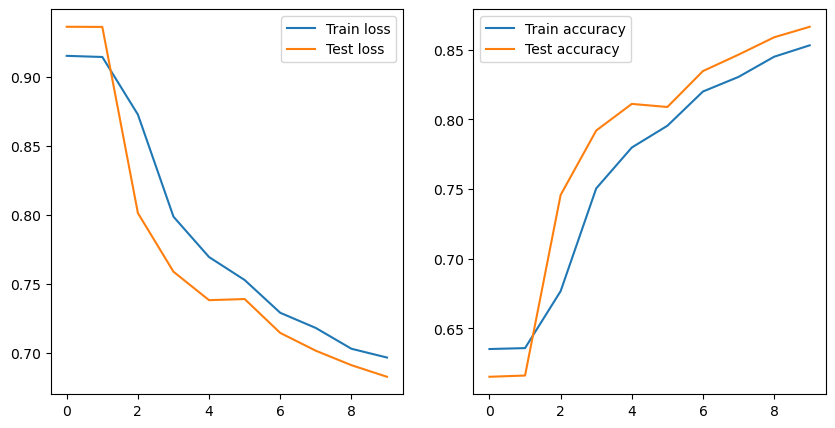

In [24]:
# plot the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train loss")
plt.plot(test_loss, label="Test loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train accuracy")
plt.plot(test_acc, label="Test accuracy")
plt.legend()
plt.show()


In [27]:
# define a cnn model with batch normalization and dropout
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(18 * 18 * 64, 300)
        self.fc2 = nn.Linear(300, 3)
        self.dropout = nn.Dropout(0.2)
        self.batch_norm1 = nn.BatchNorm1d(300)
        self.batch_norm2 = nn.BatchNorm1d(3)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = F.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.batch_norm2(self.fc2(x))
        return x
# initialize the model
cnn_model = CNN().to(device)

# define the optimizer and the loss function
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# train the model
train_loss, test_loss, train_acc, test_acc = train(cnn_model, train_loader, test_loader, criterion, optimizer, epochs=10)

Epoch 1/10.. Train loss: 0.394.. Test loss: 0.318.. Train accuracy: 0.910.. Test accuracy: 0.953
Epoch 2/10.. Train loss: 0.310.. Test loss: 0.286.. Train accuracy: 0.966.. Test accuracy: 0.977
Epoch 3/10.. Train loss: 0.275.. Test loss: 0.251.. Train accuracy: 0.981.. Test accuracy: 0.978
Epoch 4/10.. Train loss: 0.254.. Test loss: 0.247.. Train accuracy: 0.988.. Test accuracy: 0.982
Epoch 5/10.. Train loss: 0.242.. Test loss: 0.228.. Train accuracy: 0.992.. Test accuracy: 0.981
Epoch 6/10.. Train loss: 0.238.. Test loss: 0.268.. Train accuracy: 0.993.. Test accuracy: 0.983
Epoch 7/10.. Train loss: 0.222.. Test loss: 0.220.. Train accuracy: 0.996.. Test accuracy: 0.978
Epoch 8/10.. Train loss: 0.215.. Test loss: 0.230.. Train accuracy: 0.996.. Test accuracy: 0.980
Epoch 9/10.. Train loss: 0.206.. Test loss: 0.224.. Train accuracy: 0.998.. Test accuracy: 0.979
Epoch 10/10.. Train loss: 0.199.. Test loss: 0.240.. Train accuracy: 0.998.. Test accuracy: 0.985


In [28]:
# save the model
torch.save(cnn_model.state_dict(), "cnn_model.pt")


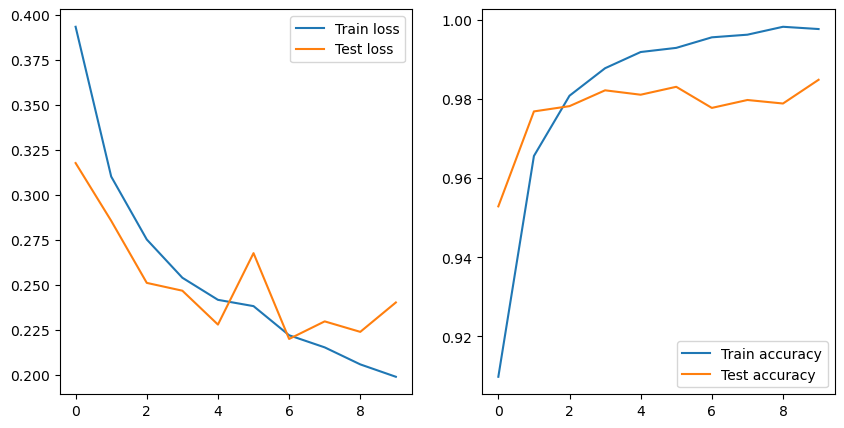

In [29]:
# plot the loss and accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train loss")
plt.plot(test_loss, label="Test loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Train accuracy")
plt.plot(test_acc, label="Test accuracy")
plt.legend()
plt.show()